# Taxi Tip prediction using scikit-learn and snap ML

In [33]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import mean_squared_error
import time
import warnings
import gc, sys

In [34]:
data=pd.read_csv('datasets/yellow_tripdata_2019-06.csv')
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-06-01 00:55:13,2019-06-01 00:56:17,1.0,0.0,1.0,N,145.0,145.0,2.0,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0
1,1,2019-06-01 00:06:31,2019-06-01 00:06:52,1.0,0.0,1.0,N,262.0,263.0,2.0,2.5,3.0,0.5,0.00,0.0,0.3,6.30,2.5
2,1,2019-06-01 00:17:05,2019-06-01 00:36:38,1.0,4.4,1.0,N,74.0,7.0,2.0,17.5,0.5,0.5,0.00,0.0,0.3,18.80,0.0
3,1,2019-06-01 00:59:02,2019-06-01 00:59:12,0.0,0.8,1.0,N,145.0,145.0,2.0,2.5,1.0,0.5,0.00,0.0,0.3,4.30,0.0
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.7,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,15.95,2.5


In [35]:
data.shape

(3936004, 18)

In [36]:
data=data[data['tip_amount']>0]

In [37]:
data.shape

(2716613, 18)

In [38]:
data=data[data['tip_amount']<=data['fare_amount']]

In [39]:
data.shape

(2713009, 18)

In [40]:
data = data[((data['fare_amount'] >=2) & (data['fare_amount'] < 200))]

In [41]:
clean_data=data.drop(['total_amount'],axis=1)

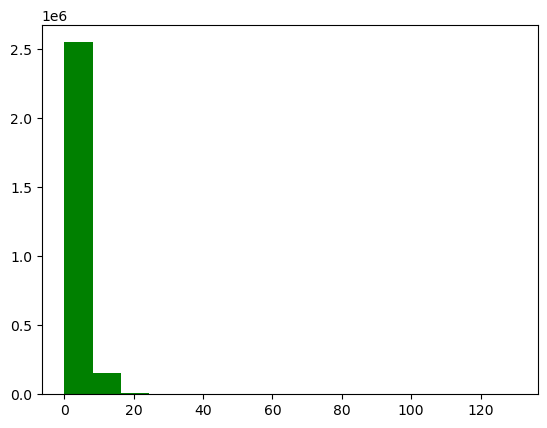

In [42]:
plt.hist(clean_data.tip_amount.values,16,histtype='bar',facecolor='g')
plt.show()

In [43]:
clean_data['tpep_pickup_datetime']=pd.to_datetime(clean_data['tpep_pickup_datetime'])
clean_data['tpep_dropoff_datetime']=pd.to_datetime(clean_data['tpep_dropoff_datetime'])

In [44]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2712719 entries, 4 to 3936000
Data columns (total 17 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           float64       
 8   DOLocationID           float64       
 9   payment_type           float64       
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  congestion_surcharge   float64       
dtypes: datetime64[ns](2), float64(13), int64(1), object(1)
memory usage: 3

In [45]:
clean_data['pickup_hour']=clean_data['tpep_pickup_datetime'].dt.hour
clean_data['dropoff_hour']=clean_data['tpep_dropoff_datetime'].dt.hour

In [46]:
clean_data.tail()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,pickup_hour,dropoff_hour
3935995,2,2019-06-17 23:31:56,2019-06-17 23:39:55,5.0,1.82,1.0,N,230.0,143.0,1.0,8.0,0.5,0.5,2.95,0.0,0.3,2.5,23,23
3935996,2,2019-06-18 00:01:57,2019-06-18 00:09:48,1.0,1.36,1.0,N,79.0,68.0,1.0,7.5,0.5,0.5,1.08,0.0,0.3,2.5,0,0
3935997,2,2019-06-17 23:57:45,2019-06-18 00:08:13,1.0,3.00,1.0,N,144.0,100.0,1.0,11.0,0.5,0.5,2.96,0.0,0.3,2.5,23,0
3935998,2,2019-06-17 22:49:23,2019-06-17 23:00:40,1.0,2.73,1.0,N,238.0,116.0,1.0,11.5,0.5,0.5,1.50,0.0,0.3,0.0,22,23
3936000,2,2019-06-17 23:41:25,2019-06-17 23:48:50,1.0,1.64,1.0,N,161.0,234.0,1.0,8.0,0.5,0.5,4.00,0.0,0.3,2.5,23,23


In [47]:
clean_data['pickup_day'] = clean_data['tpep_pickup_datetime'].dt.weekday
clean_data['dropoff_day'] = clean_data['tpep_dropoff_datetime'].dt.weekday

In [48]:
clean_data['trip_time'] = (clean_data['tpep_dropoff_datetime'] - clean_data['tpep_pickup_datetime']).dt.total_seconds()

In [49]:
clean_data = clean_data.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

In [51]:
clean_data.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,pickup_hour,dropoff_hour,pickup_day,dropoff_day,trip_time
4,1,1.0,1.70,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,2.5,0,0,5,5,737.0
5,1,2.0,1.60,1.0,N,79.0,125.0,1.0,9.5,3.0,0.5,1.00,0.0,0.3,2.5,0,0,5,5,652.0
7,1,2.0,1.20,1.0,N,79.0,249.0,1.0,7.5,3.0,0.5,1.00,0.0,0.3,2.5,0,1,5,5,488.0
9,1,1.0,8.60,1.0,N,186.0,243.0,1.0,31.5,3.0,0.5,7.05,0.0,0.3,2.5,0,1,5,5,2041.0
10,2,1.0,1.74,1.0,N,107.0,148.0,1.0,11.0,0.5,0.5,2.96,0.0,0.3,2.5,0,0,5,5,858.0
